In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from tqdm import tqdm
from datetime import timedelta

from scikeras.wrappers import KerasRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Bidirectional, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from Functions._createModel import *
from Functions._analyzeData import *
from Functions._editDatabase import getTransactionData, getAccount

plt.style.use("fivethirtyeight")

In [2]:
df = getTimeCycle(getTransactionData(getAccount("atlas")), "DAY")

budget = df["TOTAL"].cumsum()
budget.index = pd.to_datetime(df.index)
budget = budget.to_frame(name='TOTAL')
budget = addFeatures(budget)

budget = budget.rename(columns={"TOTAL": "Budget"})

df = budget

In [3]:
# Create Features
def create_features(df):
    df["Hour"] = df.index.hour
    df["DoW"] = df.index.day_of_week
    df["Quarter"] = df.index.quarter
    df["Month"] = df.index.month
    df["Year"] = df.index.year
    df["DoY"] = df.index.day_of_year
    return df

df = create_features(df)

df

,Budget,Hour,DoW,Quarter,Month,Year,DoY
DAY,,,,,,,
2000-01-01,-168000.0,0,5,1,1,2000,1
2000-01-02,-248000.0,0,6,1,1,2000,2
2000-01-03,-480000.0,0,0,1,1,2000,3
2000-01-04,-620000.0,0,1,1,1,2000,4
2000-01-05,-752000.0,0,2,1,1,2000,5
...,...,...,...,...,...,...,...
2023-12-26,178941000.0,0,1,4,12,2023,360
2023-12-27,178835000.0,0,2,4,12,2023,361
2023-12-28,178701000.0,0,3,4,12,2023,362


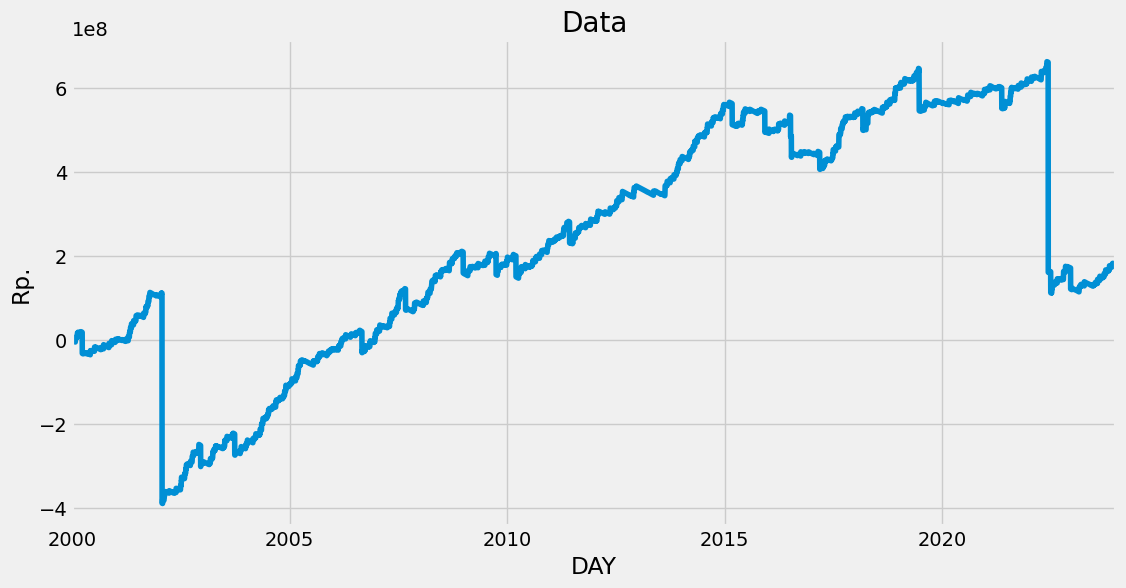

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
df["Budget"].plot(title="Data")
plt.ylabel("Rp.")
plt.grid(True)
plt.show()

          Train Size : 7888
     Validation Size : 438
           Test Size : 8765


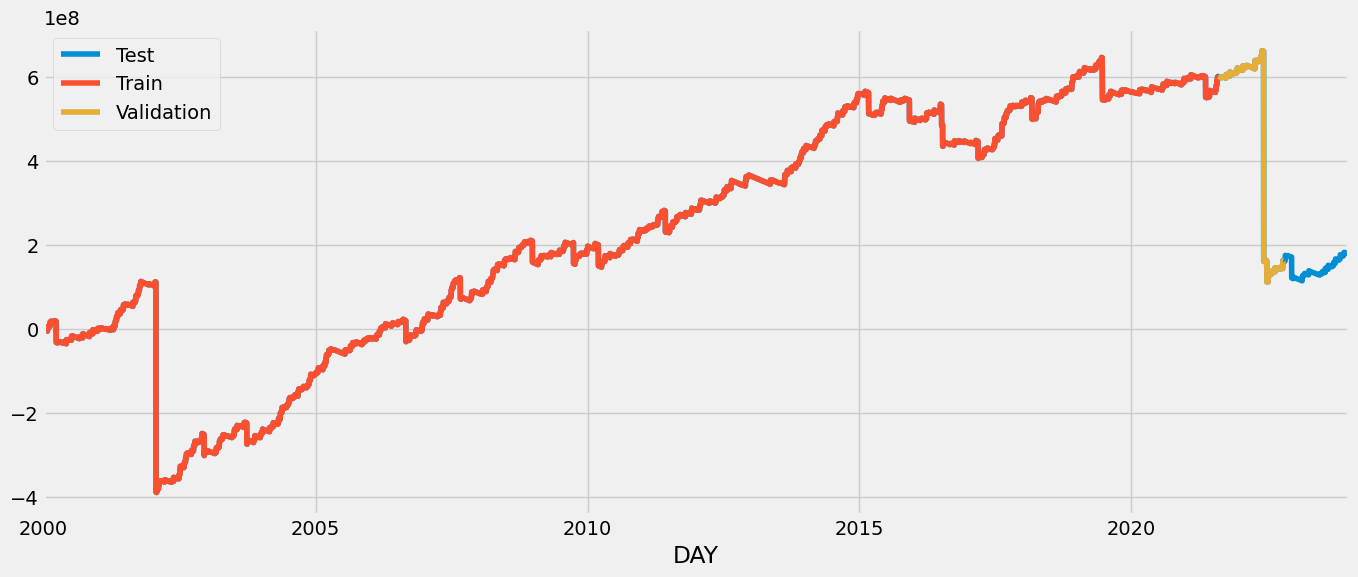

In [5]:
# Features and Target

FEATURES = ["Hour", "DoW", "Quarter", "Month", "Year", "DoY"]
TARGET = ["Budget"]

# Split Data

data_length = len(df)
train_size = 0.9
val_size = 0.05
test_size = 0.05

train, temp = train_test_split(df, train_size=train_size, shuffle=False)
val, test = train_test_split(temp, test_size=test_size/(val_size + test_size), shuffle=False)

test = df

X_train = train[FEATURES]
y_train = train[TARGET]
X_val = val[FEATURES]
y_val = val[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]


print(f"{'Train Size':>20} : {len(train)}")
print(f"{'Validation Size':>20} : {len(val)}")
print(f"{'Test Size':>20} : {len(test)}")

fig, ax = plt.subplots(figsize=(15, 6))
test["Budget"].plot(ax=ax, label="Test")
train["Budget"].plot(ax=ax, label="Train")
val["Budget"].plot(ax=ax, label="Validation")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# Normalize data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Include Time Steps

X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [7]:
def createModel():
    model = Sequential([
        Input(shape=(1, X_train_reshaped.shape[2])),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.4),
        Dense(50, activation="relu", kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.5), loss="mae")

    return model

model = KerasRegressor(model=createModel, epochs=100, batch_size=32, verbose=2)

In [8]:
tscv = TimeSeriesSplit(n_splits= int(24/4))

scores = cross_val_score(model, X_train_reshaped, y_train, cv=tscv, scoring='neg_mean_absolute_error')

mse_scores = -scores
print(f"{'MSE':>8}: {mse_scores}")
print(f"{'MMSE':>8}: {mse_scores.mean()}")
print(f"{'Std MSE':>8}: {mse_scores.std()}")

Epoch 1/100
36/36 - 4s - 122ms/step - loss: 131291736.0000
Epoch 2/100
36/36 - 0s - 2ms/step - loss: 131280344.0000
Epoch 3/100
36/36 - 0s - 2ms/step - loss: 131249576.0000
Epoch 4/100
36/36 - 0s - 2ms/step - loss: 131197648.0000
Epoch 5/100
36/36 - 0s - 2ms/step - loss: 131128880.0000
Epoch 6/100
36/36 - 0s - 2ms/step - loss: 131048208.0000
Epoch 7/100
36/36 - 0s - 3ms/step - loss: 130962664.0000
Epoch 8/100
36/36 - 0s - 3ms/step - loss: 130878544.0000
Epoch 9/100
36/36 - 0s - 3ms/step - loss: 130794400.0000
Epoch 10/100
36/36 - 0s - 2ms/step - loss: 130718904.0000
Epoch 11/100
36/36 - 0s - 2ms/step - loss: 130643816.0000
Epoch 12/100
36/36 - 0s - 2ms/step - loss: 130568960.0000
Epoch 13/100
36/36 - 0s - 2ms/step - loss: 130503208.0000
Epoch 14/100
36/36 - 0s - 2ms/step - loss: 130442680.0000
Epoch 15/100
36/36 - 0s - 2ms/step - loss: 130385824.0000
Epoch 16/100
36/36 - 0s - 2ms/step - loss: 130335368.0000
Epoch 17/100
36/36 - 0s - 2ms/step - loss: 130290488.0000
Epoch 18/100
36/36 - 

In [9]:
history = model.fit(
    X_train_reshaped, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.0001)
    ]
)

Epoch 1/300
247/247 - 5s - 22ms/step - loss: 298468288.0000 - val_loss: 471459104.0000
Epoch 2/300
247/247 - 0s - 2ms/step - loss: 295489888.0000 - val_loss: 459955712.0000
Epoch 3/300
247/247 - 0s - 2ms/step - loss: 289141984.0000 - val_loss: 441029792.0000
Epoch 4/300
247/247 - 0s - 2ms/step - loss: 280216512.0000 - val_loss: 422849344.0000
Epoch 5/300
247/247 - 0s - 2ms/step - loss: 270387328.0000 - val_loss: 390267136.0000
Epoch 6/300
247/247 - 0s - 2ms/step - loss: 253032608.0000 - val_loss: 375479008.0000
Epoch 7/300
247/247 - 0s - 2ms/step - loss: 238207232.0000 - val_loss: 331785792.0000
Epoch 8/300
247/247 - 0s - 2ms/step - loss: 215046528.0000 - val_loss: 312273184.0000
Epoch 9/300
247/247 - 0s - 2ms/step - loss: 199610512.0000 - val_loss: 302445472.0000
Epoch 10/300
247/247 - 0s - 2ms/step - loss: 182796688.0000 - val_loss: 276218528.0000
Epoch 11/300
247/247 - 0s - 2ms/step - loss: 167052656.0000 - val_loss: 247829264.0000
Epoch 12/300
247/247 - 0s - 2ms/step - loss: 156621

In [10]:
# # Graph History

# loss = history.history["loss"]
# val_loss = history.history["val_loss"]

# plt.figure(figsize=(12, 6))
# plt.plot(loss, label="Training Loss")
# plt.plot(val_loss, label="Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.legend()
# plt.title("Training and Validation Loss")
# plt.show()

In [11]:
# Model Performance

predictions = model.predict(X_test_reshaped)
predictions = predictions.flatten()
test["Prediction"] = predictions

274/274 - 1s - 4ms/step


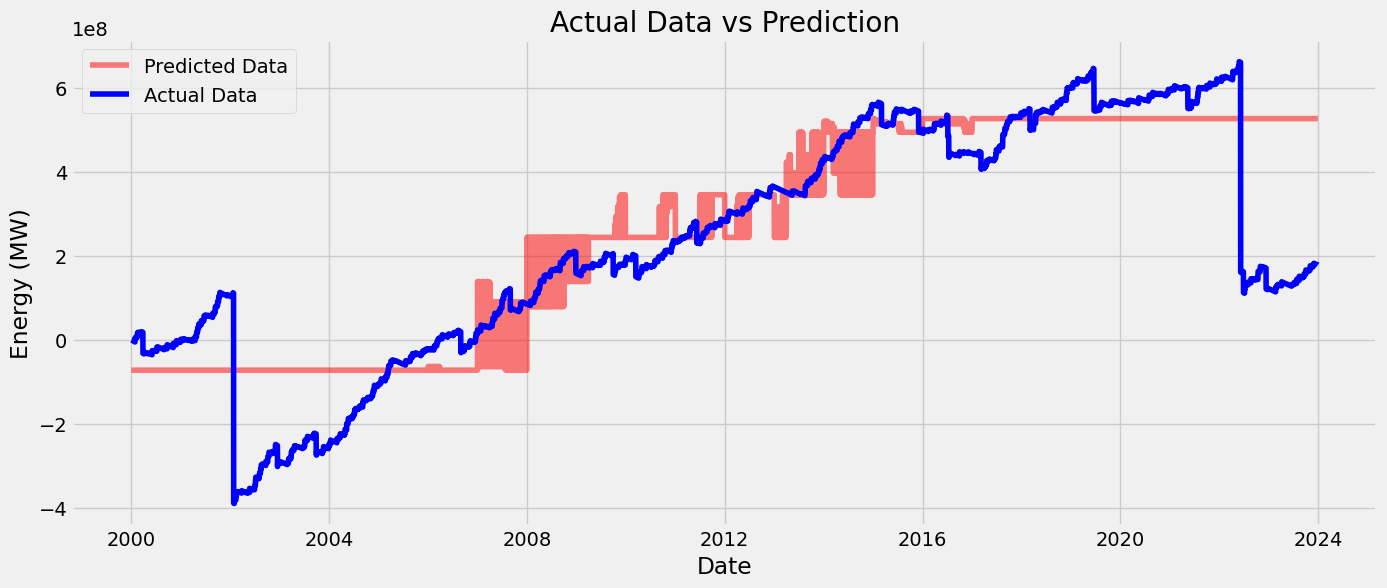

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(test["Prediction"], label="Predicted Data", alpha=0.5, color='red')
plt.plot(df["Budget"], label="Actual Data", color='blue')
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.title("Actual Data vs Prediction")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# Performance Evaluation

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = math.sqrt(mse)
mape = np.mean(np.abs((np.array(y_test) - np.array(predictions)) / np.array(y_test))) * 100

print(f"{'MSE':>6} : {mse:>7.4f}")
print(f"{'MAE':>6} : {mae:>7.4f}")
print(f"{'RMSE':>6} : {rmse:>7.4f}")
print(f"{'MAPE':>6} : {mape:>7.4f} %")


   MSE : 18456091933492520.0000
   MAE : 96135723.0706
  RMSE : 135853199.9384
  MAPE : 1587.3802 %


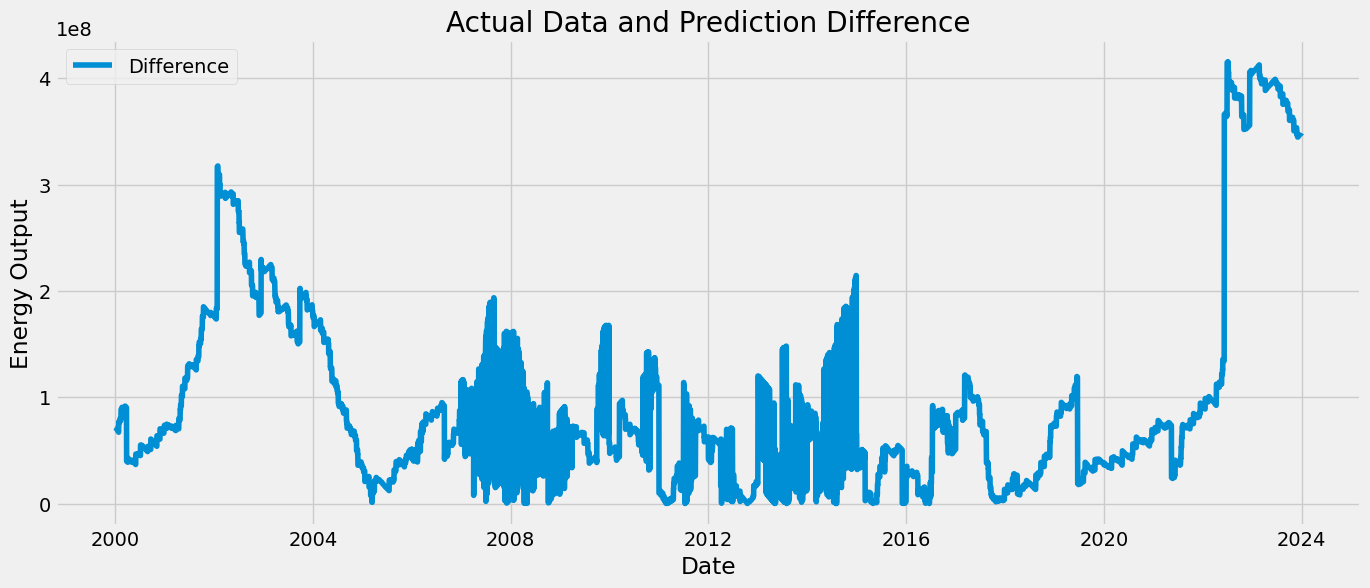

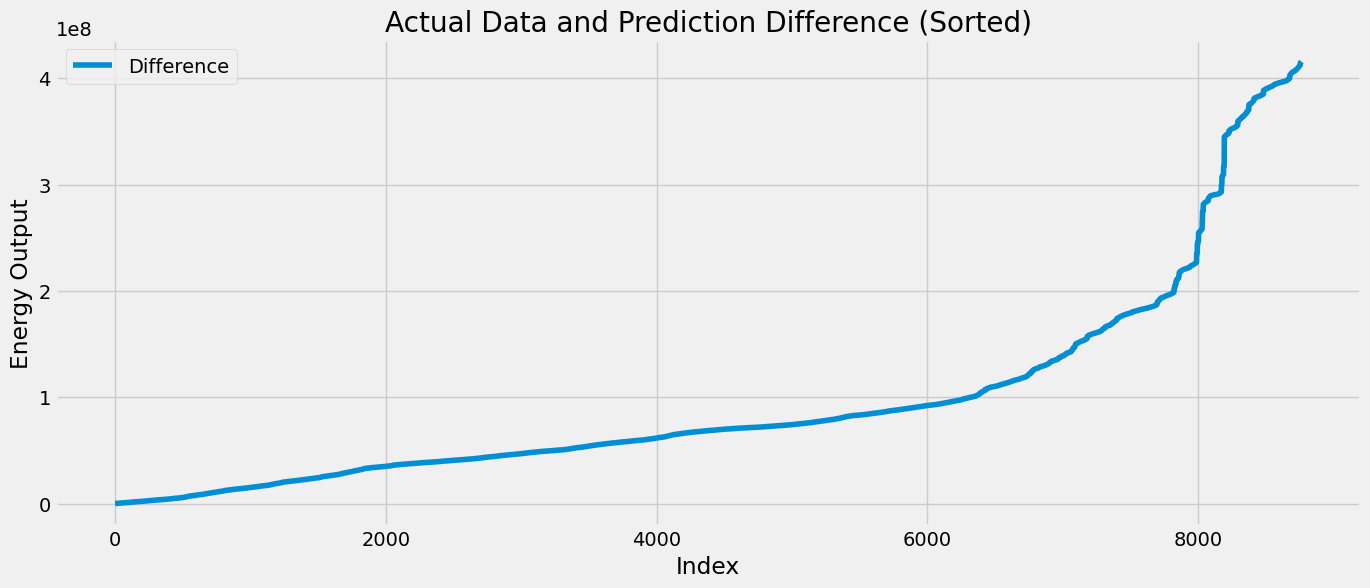

In [14]:
# Evaluation Difference

delta = np.abs(np.array(test["Budget"]) - np.array(test["Prediction"]))

plt.figure(figsize=(15, 6))
plt.plot(test.index, delta, label="Difference")
plt.xlabel("Date")
plt.ylabel("Energy Output")
plt.title("Actual Data and Prediction Difference")
plt.grid(True)
plt.legend()
plt.show()

sorted_delta = np.sort(delta)
plt.figure(figsize=(15, 6))
plt.plot(sorted_delta, label="Difference")
plt.xlabel("Index")
plt.ylabel("Energy Output")
plt.grid(True)
plt.legend()
plt.title("Actual Data and Prediction Difference (Sorted)")
plt.show()


In [15]:
# Analyzing Uncertainty

limit = np.sum(np.array(delta)) / ((1 + 5 ** 0.5) / 2) #Golden Ratio

temp = 0
i = 0
while temp < limit:
    temp += sorted_delta[i]
    i += 1

uncertainty = sorted_delta[i]

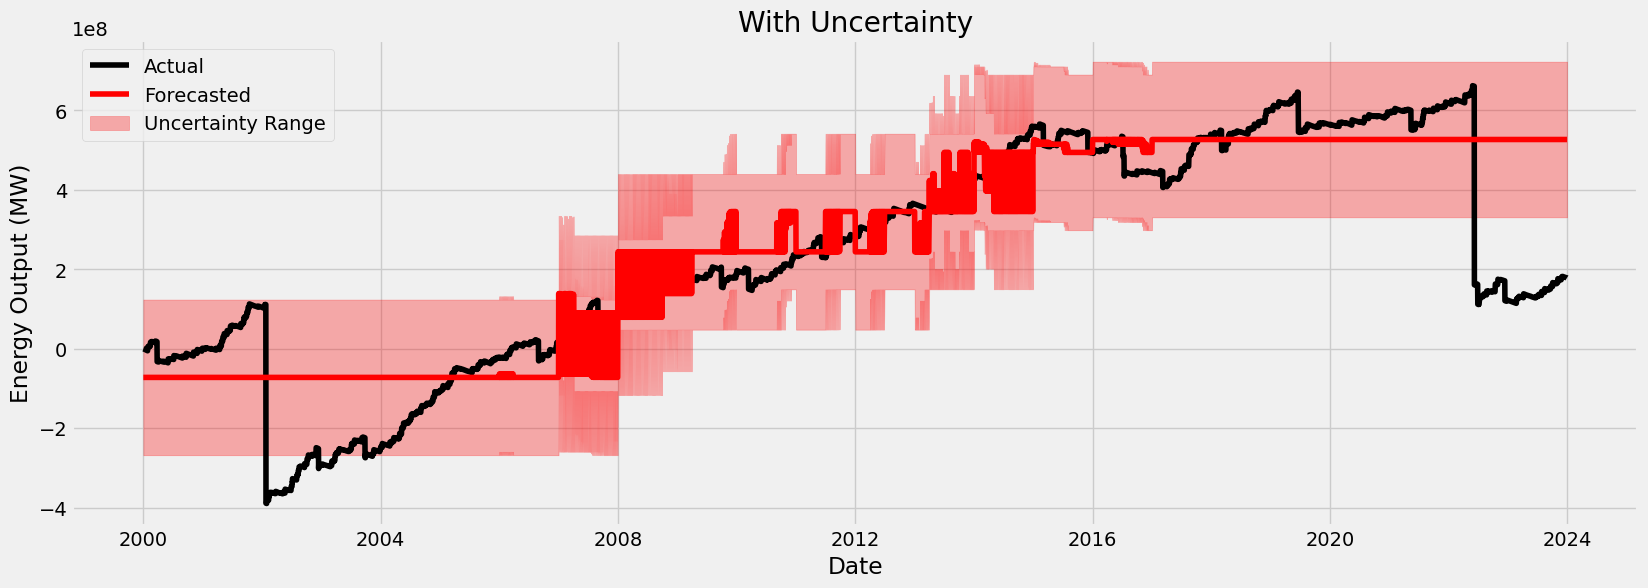

In [16]:
# Golden Ratio Uncertainty

predictions = np.array(predictions).flatten()

predictions_upper = predictions + uncertainty
predictions_lower = predictions - uncertainty

data_shown = 20000

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df.index[-data_shown:], y_test[-data_shown:], label="Actual", color="black")
ax.plot(df.index[-data_shown:], predictions[-data_shown:], color="red", label="Forecasted")
ax.fill_between(df.index[-data_shown:], predictions_lower[-data_shown:], 
                predictions_upper[-data_shown:], 
                color="red", alpha=0.3, label="Uncertainty Range")
ax.set_title("With Uncertainty")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Output (MW)")
ax.legend()
plt.grid(True)
plt.show()

100%|██████████| 8765/8765 [00:00<00:00, 31962.58it/s]


395373776.0


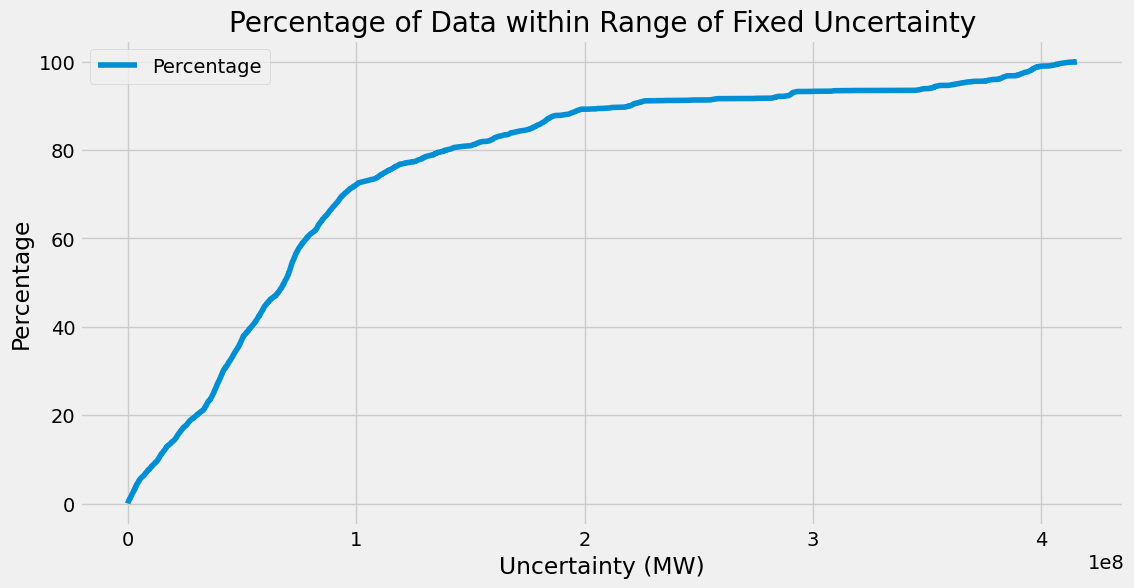

In [17]:
# Fixed Uncertainty

y_test = np.array(y_test).flatten()

fixed_uncertainty = []
isOK = False
FU = 0

for x in tqdm(sorted_delta):
    uncertainty = x

    predictions_upper = predictions + uncertainty
    predictions_lower = predictions - uncertainty

    within_range = np.sum((y_test >= predictions_lower) & (y_test <= predictions_upper))
    fixed_uncertainty.append((within_range / len(y_test)) * 100)

    if fixed_uncertainty[-1] > 98 and not isOK:
        FU = x
        print(FU)
        isOK = True

plt.figure(figsize=(12, 6))
plt.plot(sorted_delta, fixed_uncertainty, label="Percentage")
plt.legend()
plt.title("Percentage of Data within Range of Fixed Uncertainty")
plt.xlabel("Uncertainty (MW)")
plt.ylabel("Percentage")
plt.grid(True)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 22592.53it/s]


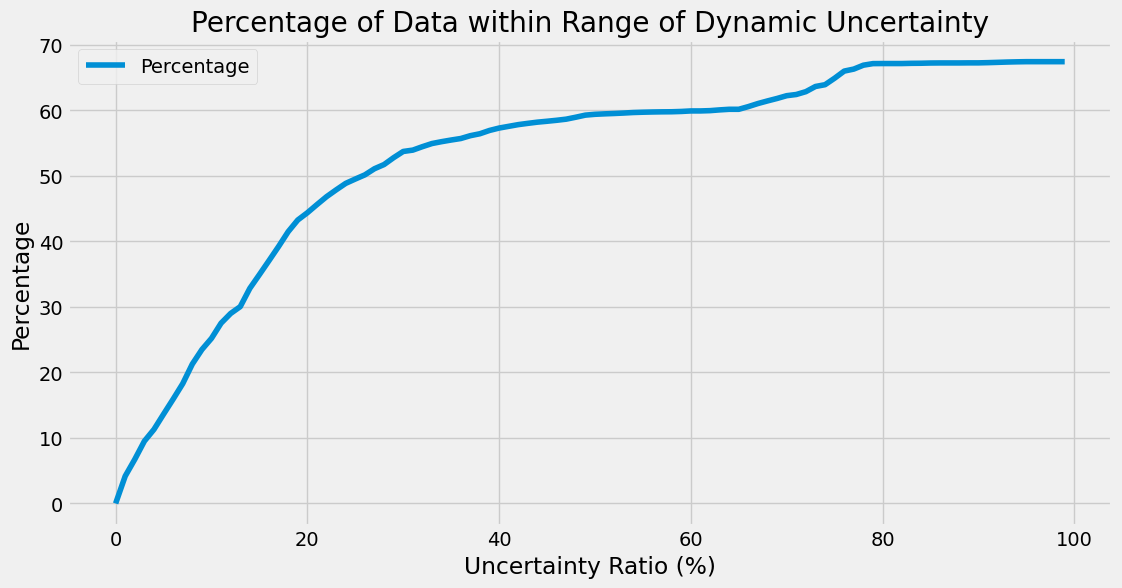

In [18]:
# Dynamic Uncertainty

dynamic_uncertainty = []
isOK = False
DU = 0

for ratio in tqdm(range(100)):
    uncertainty = predictions * (ratio / 100)

    predictions_upper = predictions + uncertainty
    predictions_lower = predictions - uncertainty

    within_range = np.sum((y_test >= predictions_lower) & (y_test <= predictions_upper))
    dynamic_uncertainty.append((within_range / len(y_test)) * 100)

    if dynamic_uncertainty[-1] > 98 and not isOK:
        DU = ratio
        print(DU)
        isOK = True

plt.figure(figsize=(12, 6))
plt.plot(np.arange(100), dynamic_uncertainty, label="Percentage")
plt.legend()
plt.title("Percentage of Data within Range of Dynamic Uncertainty")
plt.xlabel("Uncertainty Ratio (%)")
plt.ylabel("Percentage")
plt.grid(True)
plt.show()

In [19]:
# Creating Future Data

last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 365 * 4 + 1)]

last_sequence = X_test[-1]

future = pd.DataFrame(index=future_dates, columns=TARGET + FEATURES)
future = create_features(future)

X_future = future[FEATURES]
y_future = future[TARGET]

X_future = scaler.transform(X_future)
X_future = X_future.reshape((X_future.shape[0], 1, X_future.shape[1]))

In [20]:
# Predict the future
future[TARGET] = model.predict(X_future)

future["F_UpperLimit"] = future[TARGET] + FU
future["F_LowerLimit"] = future[TARGET] - FU

future["D_UpperLimit"] = future[TARGET] * (1 + DU/100)
future["D_LowerLimit"] = future[TARGET] * (1 - DU/100)

46/46 - 0s - 1ms/step


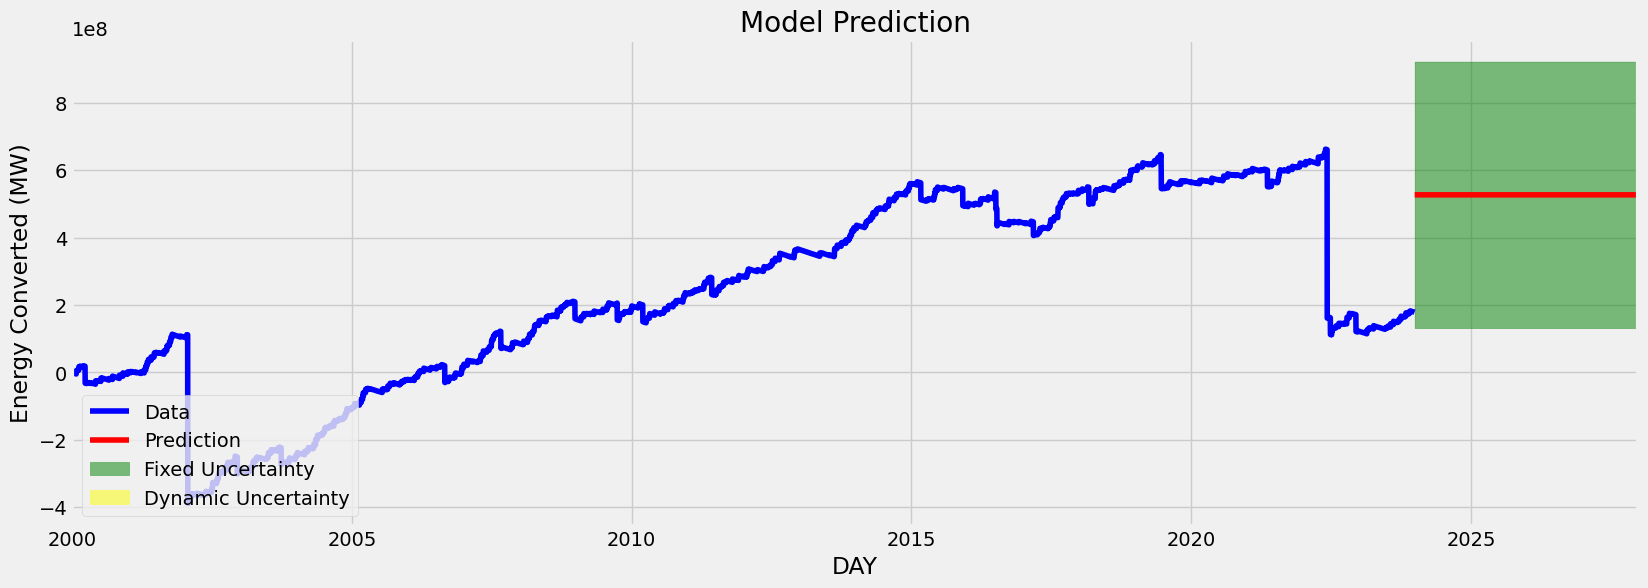

In [21]:
fig, ax = plt.subplots(figsize=(18, 6))
df[TARGET].plot(ax=ax, color="blue")
future[TARGET].plot(ax=ax, color="red")
ax.fill_between(future.index, 
                future['F_LowerLimit'], future['F_UpperLimit'],
                color='green', alpha=0.5)
ax.fill_between(future.index, future['D_LowerLimit'], 
                future['D_UpperLimit'],
                color='yellow', alpha=0.5)
ax.set_ylabel("Energy Converted (MW)")
ax.legend(["Data", "Prediction", "Fixed Uncertainty", "Dynamic Uncertainty"], loc='lower left')
plt.grid(True)
plt.title("Model Prediction")
plt.show()